# State as Messages

What if we want to keep a log of the conversation? Something quite common in LLM applications.
How could we do that across a traditional langgraph graph?

The answer is by defining a state that allows us to add messages as the graph gets executed!

But wait, what are messages?

## Messages

[Messages](https://python.langchain.com/v0.2/docs/concepts/#messages), capture different roles within a conversation. 

LangChain supports various message types, including 

1. `HumanMessage` - message from the user 
2. `AIMessage` - message from the chat model
3. `SystemMessage` - message that instructs the behavior of the chat model
4. `ToolMessage` - message from a tool call (calling a tool that performs some action) 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [ ]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

In [13]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage

from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So, you work in AI engineering?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lucas"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about fine tunning local LLMs.", name="Lucas"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So, you work in AI engineering?
================================ Human Message =================================
Name: Lucas

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lucas

I want to learn about fine tunning local LLMs.


So, messages store the exchanges between model and user throughout a conversation. We can have them as keys in a state for a graph
so that we can keep a log of the interactions throughout the graph and so that the chat models within a graph can have the context information
for what happened before.

## Using messages as state



Let's think about what do we need to have these messages as parts of a graph state?
We need:
1. Something that stores the messages (like a list)
2. Something that allows us to add more messages into this list as the graph is executed
3. Something that can log metadata about the objects being added to the conversation so we can inspect them during debugging.

In [14]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

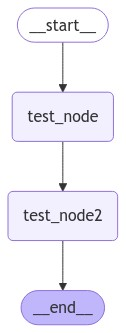

In [17]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from IPython.display import display, Image

def my_node(state):
    # Get current messages
    messages = state["messages"]
    
    # Add a new message
    new_message = HumanMessage(content="message 1", name="Lucas")
    
    # Return updated state
    return {"messages": [new_message]}

def my_node2(state):
    # Get current messages
    messages = state["messages"]
    
    # Add a new message
    new_message = HumanMessage(content="message 2", name="Lucas")
    
    # Return updated state
    return {"messages": [new_message]}

# Create workflow
workflow = StateGraph(MessagesState)

# Add the node
workflow.add_node("test_node", my_node)
workflow.add_node("test_node2", my_node2)

# Set the entry point
workflow.set_entry_point("test_node")
# workflow.add_edge(START, "test_node")

# Set the exit point
workflow.add_edge("test_node", "test_node2")
workflow.add_edge("test_node2", END)

# Compile the graph
graph = workflow.compile()


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
# Run the graph with initial state
result = graph.invoke({
    "messages": messages  # Using messages defined above
})

result

{'messages': [HumanMessage(content='message 2', additional_kwargs={}, response_metadata={}, name='Lucas')]}

Wait! Why do we only have one message in the final output?

## Reducers

In langgraph the default is to [override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
However what we want is to append messages to our `messages` state key throughout the graph's execution.
 
For that we use something called [`reducer` functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers), which allow us to specify
how the states get updated. To do that we annotate the `messages` key with the `add_messages` reducer function as metadata.

In [19]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Now, if we take the same graph as before:

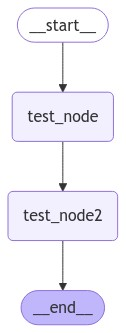

In [21]:

def my_node(state):
    # Get current messages
    messages = state["messages"]
    
    # Add a new message
    new_message = HumanMessage(content="message 1", name="Lucas")
    
    # Return updated state
    return {"messages": [new_message]}

def my_node2(state):
    # Get current messages
    messages = state["messages"]
    
    # Add a new message
    new_message = HumanMessage(content="message 2", name="Lucas")
    
    # Return updated state
    return {"messages": [new_message]}

# Create workflow
workflow = StateGraph(MessagesState)

# Add the node
workflow.add_node("test_node", my_node)
workflow.add_node("test_node2", my_node2)

# Set the entry point
workflow.set_entry_point("test_node")

# Set the exit point
workflow.add_edge("test_node", "test_node2")
workflow.add_edge("test_node2", END)

# Compile the graph
graph = workflow.compile()



try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
# Run the graph with initial state
result = graph.invoke({
    "messages": []  # Using messages defined above
})
result

{'messages': [HumanMessage(content='message 1', additional_kwargs={}, response_metadata={}, name='Lucas', id='068d7e31-1758-4c62-8fb2-5b560934329f'),
  HumanMessage(content='message 2', additional_kwargs={}, response_metadata={}, name='Lucas', id='59843e3d-ac69-48bb-9683-779f0cb953fb')]}

We see that now both messages are stored inside after the graph's execution.

LangGraph allows us to simplify this a bit so we don't have to be writing this overcomplicated-looking class everytime:

In [23]:
from langgraph.graph import MessagesState

Now, we can see a simple example actually using LLMs + messages as state.

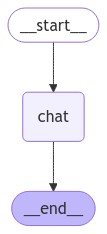

In [25]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

# Initialize the LLM
llm = ChatOpenAI()

# Define a node that uses the LLM to respond
def chat_node(state):
    # Get messages from state
    messages = state["messages"]
    
    # Get response from LLM
    response = llm.invoke(messages)
    
    # Add response to messages
    new_messages = messages + [response]
    
    # Return updated state
    return {"messages": new_messages}

# Create workflow
workflow = StateGraph(MessagesState)

# Add the chat node
workflow.add_node("chat", chat_node)

# Set entry point
workflow.set_entry_point("chat")

# Add edge to end
workflow.add_edge("chat", END)

# Compile the graph
app = workflow.compile()


display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
# Run the graph with an initial message
result = app.invoke({
    "messages": ["Tell me a joke about pancakes."]
})

result


{'messages': [HumanMessage(content='Tell me a joke about pancakes.', additional_kwargs={}, response_metadata={}, id='83f76ab8-00f1-43b5-9734-b08ed0880a02'),
  AIMessage(content='Why did the pancake go to therapy?\n\nBecause it was feeling a little flat!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 14, 'total_tokens': 32, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-d9b3c6ed-fdf2-4c8b-8b97-78c4153fd23b-0', usage_metadata={'input_tokens': 14, 'output_tokens': 18, 'total_tokens': 32, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [28]:
result = app.invoke({
    "messages": [HumanMessage("Tell me a joke about pancakes.")]
})

result

{'messages': [HumanMessage(content='Tell me a joke about pancakes.', additional_kwargs={}, response_metadata={}, id='75eabed6-1d30-47c4-8b3e-7c9ae6469e75'),
  AIMessage(content='Why did the pancake go to therapy?\nBecause it was feeling flat!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 14, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4e8fa57d-c4af-4418-b2c5-8ff2b41dc08c-0', usage_metadata={'input_tokens': 14, 'output_tokens': 16, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}